The **Loan Charge-Off Prediction** Challenge

Data is available at https://raw.githubusercontent.com/bot13956/Monte_Carlo_Simulation_Loan_Status/master/loan_timing.csv .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as ll
from pandas_profiling import ProfileReport

In [2]:
data = pd.read_csv('loan_timing.csv')
data.head()

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN


Transform the data to work with survival models where we separate it into
events (`chargeoff == True`) and right-censored samples (`chargeoff == False`).

In [3]:
data['chargeoff'] = ~data['days from origination to chargeoff'].isna()
data['t'] = data.apply(lambda x: x[0] if not x[2] else x[1], axis=1)
data[9:19]

,days since origination,days from origination to chargeoff,chargeoff,t
9,438,NaN,False,438.0
10,675,NaN,False,675.0
11,336,NaN,False,336.0
12,51,NaN,False,51.0
13,117,NaN,False,117.0
14,327,78.0,True,78.0
15,400,390.0,True,390.0
16,721,362.0,True,362.0
17,562,NaN,False,562.0
18,101,NaN,False,101.0


### Exploration

First we do some basic EDA and look at the empirical data through the lens of a KM model.

In [4]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

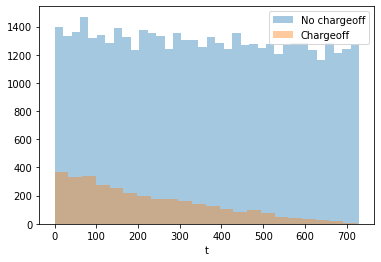

In [5]:
sns.distplot(data[~data.chargeoff]['t'], kde=False, label='No chargeoff')
sns.distplot(data[data.chargeoff]['t'], kde=False, label='Chargeoff')
plt.legend()
plt.show()

In [6]:
survival_data = data[['t', 'chargeoff']].copy()

end_time = 365 * 3
end_time

1095

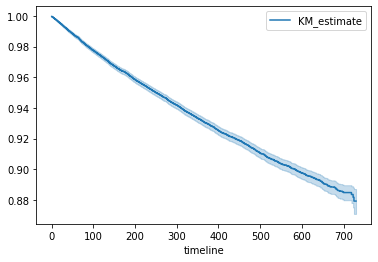

In [7]:
km_model = ll.KaplanMeierFitter().fit(survival_data['t'], survival_data['chargeoff'])

km_model.plot()
plt.show()

### Survival Models

The task is to predict the fraction of charged-off loans after 3 years. The data only contains event up to ~2 years out so we need some extrapolation. In the absence of any more predictors we opt to fit some parametric models to the data and check the AIC for goodness of fit.

In [8]:
survival_data['t'] += 0.01

weibull_model = ll.WeibullFitter().fit(survival_data['t'], survival_data['chargeoff'], timeline=range(end_time + 1))
exponential_model = ll.ExponentialFitter().fit(survival_data['t'], survival_data['chargeoff'], timeline=range(end_time + 1))
lognormal_model = ll.LogNormalFitter().fit(survival_data['t'], survival_data['chargeoff'], timeline=range(end_time + 1))

In [9]:
print(f'Weibull: {weibull_model.AIC_:.{3}f}')
print(f'Exponential: {exponential_model.AIC_:.{3}f}')
print(f'Lognormal: {lognormal_model.AIC_:.{3}f}')

Weibull: 63197.110
Exponential: 63265.205
Lognormal: 63347.681


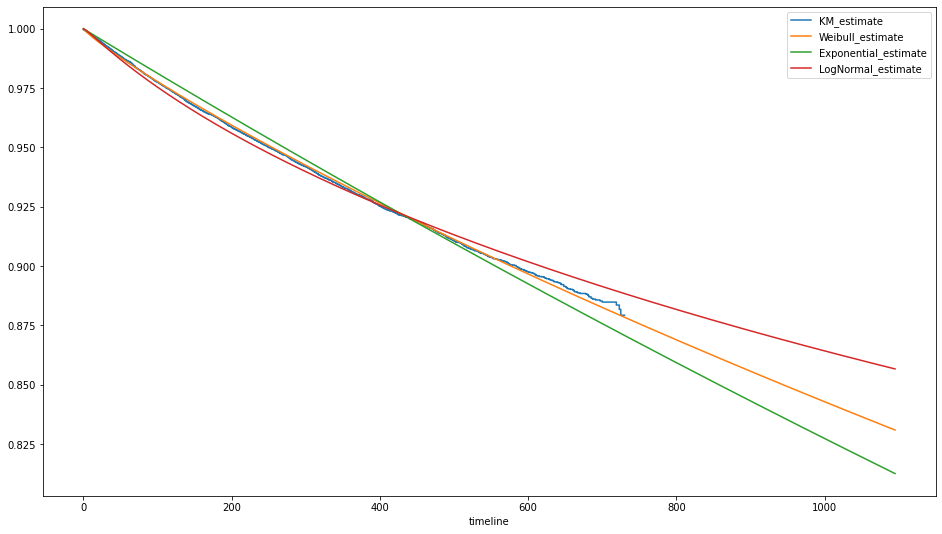

In [10]:
km_model.plot_survival_function(ci_show=False, figsize=(16,9))
weibull_model.plot_survival_function(ci_show=False)
exponential_model.plot_survival_function(ci_show=False)
lognormal_model.plot_survival_function(ci_show=False)
plt.show()

### Weibull Model Estimate

Clearly the Weibull model shows the best fit. So we use it to predict the fraction of charged-off loans after 3 years.

In [11]:
print(f'Predicted fraction of charged-off loans at {end_time} days: {1 - weibull_model.survival_function_at_times(end_time).squeeze():.{3}f}')
ci = weibull_model.confidence_interval_survival_function_.iloc[-1].squeeze().values
print(f'95% confidence interval: [{1 - ci[1]:.{3}f}, {1 - ci[0]:.{3}f}]')


Predicted fraction of charged-off loans at 1095 days: 0.169
95% confidence interval: [0.162, 0.176]
